<a href="https://colab.research.google.com/github/brianju0218/MLE_S25_Project_Brian_Ju/blob/main/notebooks/Path_2_5_Damage%26Location_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import glob
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.signal import detrend

def load_data(directory, locations=['A', 'B', 'C'], frequency='300.0kHz', runs=None, time_limit=100e-6):
    """Loads time-series data for CNN training with both location and damage classification."""
    data = []
    labels_damage = []
    labels_location = []

    for location in locations:
        file_pattern = os.path.join(directory, f"*_{frequency}_{location}_*_run_*.csv")
        files = glob.glob(file_pattern)
        print(f"Using file pattern: {file_pattern}")
        print(f"Found {len(files)} files matching criteria.")

        for file in files:
            match = re.search(r'_(\d+)g_run_(\d+)', file)
            if match:
                damage = int(match.group(1))  # Extract damage level
                run_num = int(match.group(2))

                if (runs is None) or (run_num < runs):
                    df = pd.read_csv(file)

                    if 's5' not in df.columns or 'Time [s]' not in df.columns:
                        print(f"Skipping file {file} due to missing columns.")
                        continue

                    df_filtered = df[df['Time [s]'] <= time_limit]
                    s5_values = df_filtered['s5'].values
                    s5_values = detrend(s5_values)

                    if len(s5_values) > 0:
                        data.append(s5_values)
                        labels_damage.append(damage)
                        labels_location.append(location)

    # Pad sequences
    max_length = max(len(seq) for seq in data)
    data = pad_sequences(data, maxlen=max_length, padding='post', dtype='float32')

    print(f"Loaded {len(data)} valid sequences.")
    return np.array(data), np.array(labels_damage), np.array(labels_location)

In [ ]:
# Set data directory (for Google Colab, mount Google Drive)
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2"

# Load data
X, y_damage, y_location = load_data(data_dir, locations=['A', 'B', 'C'], runs=None)

Mounted at /content/drive
Using file pattern: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/*_300.0kHz_A_*_run_*.csv
Found 600 files matching criteria.
Using file pattern: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/*_300.0kHz_B_*_run_*.csv
Found 600 files matching criteria.
Using file pattern: /content/drive/MyDrive/Colab Notebooks/MLE Project/300.0kHz_2/*_300.0kHz_C_*_run_*.csv
Found 600 files matching criteria.
Loaded 1800 valid sequences.


In [ ]:
import numpy as np
# Save arrays X and y_location and y_damage
np.savez("/content/drive/MyDrive/Colab Notebooks/MLE Project/X_y_data_2_300.0kHz.npz", X=X, y_location=y_location, y_damage=y_damage)

In [1]:
# Load in X and y (faster)
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
data = np.load("/content/drive/MyDrive/Colab Notebooks/MLE Project/X_y_data_2_300.0kHz.npz")
print(data.files)
X = data["X"]
y_location = data["y_location"]
y_damage = data["y_damage"]

Mounted at /content/drive
['X', 'y_location', 'y_damage']


In [2]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Standardize
X = (X - np.mean(X)) / np.std(X)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
damage_bins = [0, 20, 40, 60, 80, 100]
y_damage = np.digitize(y_damage, bins=damage_bins) - 1  # 0-5
y_damage_cat = to_categorical(y_damage, num_classes=6)

loc_encoder = LabelEncoder()
y_location_enc = loc_encoder.fit_transform(y_location)  # 0-2
y_location_cat = to_categorical(y_location_enc, num_classes=3)

In [3]:
print(y_damage_cat.shape)
print(y_location_cat.shape)

(1800, 6)
(1800, 3)


In [4]:
# Create combined labels like 'A_20g', 'B_0g', etc.
combined_labels = np.array([
    "Healthy" if dmg == 0 else f"{loc}_{damage_bins[dmg]}"
    for loc, dmg in zip(y_location, y_damage)
])
# Your desired label order
ordered_labels = ['Healthy',
                  'A_20', 'A_40', 'A_60', 'A_80', 'A_100',
                  'B_20', 'B_40', 'B_60', 'B_80', 'B_100',
                  'C_20', 'C_40', 'C_60', 'C_80', 'C_100']

# Create encoder and fit to desired order
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(ordered_labels)  # Manually set class order
y_combined_encoded = label_encoder.transform(combined_labels)
y_combined_cat = to_categorical(y_combined_encoded)
print("Combined class labels:", np.unique(combined_labels))
print("Encoded values:", np.unique(y_combined_encoded))

Combined class labels: ['A_100' 'A_20' 'A_40' 'A_60' 'A_80' 'B_100' 'B_20' 'B_40' 'B_60' 'B_80'
 'C_100' 'C_20' 'C_40' 'C_60' 'C_80' 'Healthy']
Encoded values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [5]:
# One-hot encode the integer labels for softmax output
y_categorical = to_categorical(y_combined_encoded, num_classes=len(ordered_labels))

print(f"Encoded labels shape: {y_categorical.shape}")
print(f"Classes: {label_encoder.classes_}")

Encoded labels shape: (1800, 16)
Classes: ['Healthy' 'A_20' 'A_40' 'A_60' 'A_80' 'A_100' 'B_20' 'B_40' 'B_60' 'B_80'
 'B_100' 'C_20' 'C_40' 'C_60' 'C_80' 'C_100']


In [6]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
print(f'training data size: ', X_train.shape)
print(f'training data labels size: ', y_train.shape)
print(f'testing data size: ', X_test.shape)
print(f'testing data labels size: ', y_test.shape)

training data size:  (1440, 334, 1)
training data labels size:  (1440, 16)
testing data size:  (360, 334, 1)
testing data labels size:  (360, 16)


# Combined Label Output

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
import random
import os

# Set seed for NumPy, Python, and TensorFlow
seed_value = 42  # You can pick any fixed number
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Ensure TensorFlow runs in a deterministic manner
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Define the model
model = Sequential([
    Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='softmax')  # 16 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 332, 3)         │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 166, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 164, 3)         │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 82, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        15,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,890 (65.98 KB)

 Trainable params: 16,890 (65.98 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=200,  # Adjust based on performance
    batch_size=64,  # Common choice, can be tuned
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.1056 - loss: 2.9819 - val_accuracy: 0.1556 - val_loss: 2.7043
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1646 - loss: 2.7114 - val_accuracy: 0.1556 - val_loss: 2.6812
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1722 - loss: 2.6714 - val_accuracy: 0.1556 - val_loss: 2.6615
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1758 - loss: 2.6529 - val_accuracy: 0.1556 - val_loss: 2.6353
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1685 - loss: 2.6286 - val_accuracy: 0.1556 - val_loss: 2.6082
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1766 - loss: 2.6082 - val_accuracy: 0.1556 - val_loss: 2.5599
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1868 - loss: 2.5520 - val_accuracy: 0.1556 - val_loss: 2.5201
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1883 - loss: 2.5204 - val_accuracy: 0.

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MLE Project/cnn_model.keras')  # Saves architecture + weights + optimizer state

In [ ]:
# Evaluate on training data
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}")

# Evaluate on testing data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.8146
Test Accuracy: 0.7917


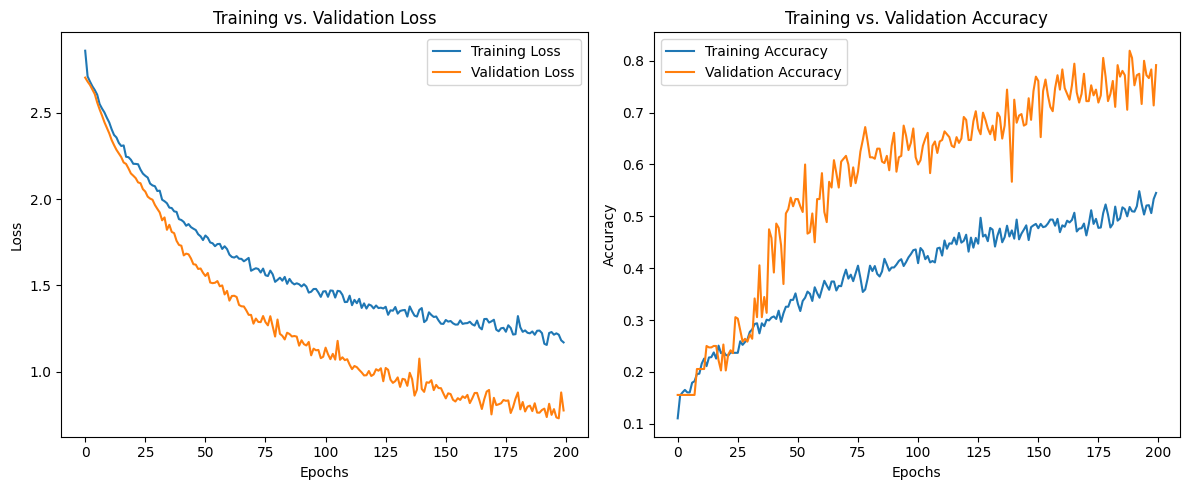

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class indices
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

       A_100       0.88      0.60      0.71        25
        A_20       0.38      0.40      0.39        15
        A_40       0.25      0.05      0.08        21
        A_60       0.59      1.00      0.74        26
        A_80       0.71      0.87      0.78        23
       B_100       1.00      1.00      1.00        17
        B_20       1.00      1.00      1.00        18
        B_40       1.00      1.00      1.00        19
        B_60       1.00      1.00      1.00        18
        B_80       1.00      1.00      1.00        18
       C_100       0.68      0.94      0.79        18
        C_20       0.00      0.00      0.00        22
        C_40       1.00      1.00      1.00        24
        C_60       0.90      1.00      0.95        19
        C_80       0.92      0.52      0.67        21
     Healthy       0.71      1.00      0.83        56

    accuracy                           0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


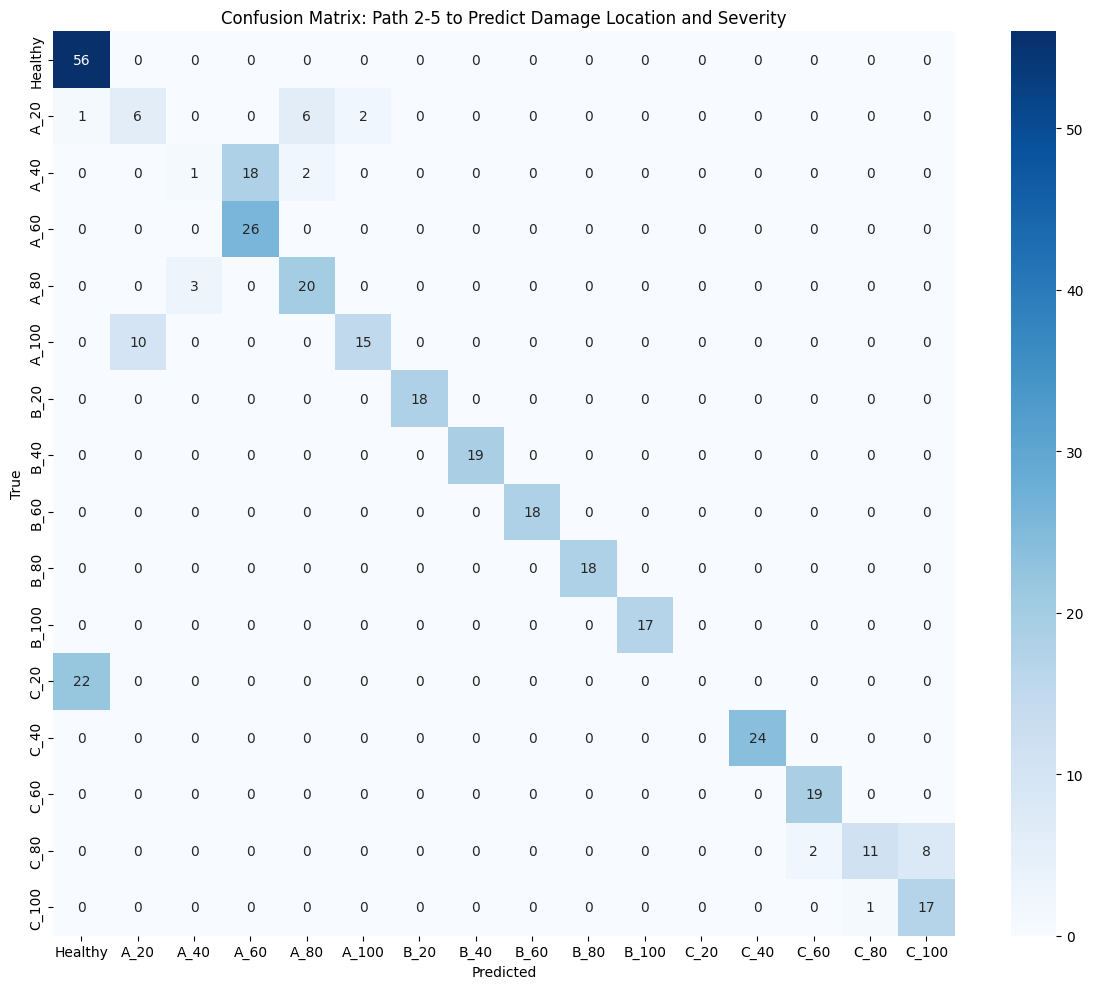

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Decode labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_true_labels = label_encoder.inverse_transform(y_true)

# Classification Report
print(classification_report(y_true_labels, y_pred_labels))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=label_encoder.transform(ordered_labels))

# Plot with correct label names
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, xticklabels=ordered_labels, yticklabels=ordered_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Path 2-5 to Predict Damage Location and Severity")
plt.tight_layout()
plt.show()

**hyperparameter tuning**

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

RANDOM_SEED = 42

def build_model(hp):
    # Set all seeds to ensure reproducibility
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)
    set_random_seed(RANDOM_SEED)

    model = Sequential()

    # First Conv1D + BatchNorm + Pool
    model.add(Conv1D(
        filters=hp.Choice('filters_1', values=[16, 32, 64]),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5, 7]),
        activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Second Conv1D + BatchNorm + Pool
    model.add(Conv1D(
        filters=hp.Choice('filters_2', values=[32, 64]),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Dropout to prevent overfitting
    model.add(Dropout(hp.Choice('dropout', values=[0.2, 0.3, 0.5])))

    model.add(Flatten())
    model.add(Dense(hp.Choice('dense_units', values=[32, 64, 128]), activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))  # 16-class output

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='cnn_tuning',
    project_name='cnn'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tests hyperparameters for 30 epochs - capping the epochs here helps save on time and assumes that the best performing hyperparameters for this number of epochs will continue to be the best performing hyperparameters for a greater number of epochs

In [ ]:
tuner.search(X_train, y_train,
             epochs=30,
             batch_size=32,
             validation_split=0.2,
             verbose=1)

Trial 10 Complete [00h 00m 44s]
val_accuracy: 0.1944444477558136

Best val_accuracy So Far: 0.8576388955116272
Total elapsed time: 00h 09m 21s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

train_loss, train_acc = best_model.evaluate(X_train, y_train)
test_loss, test_acc = best_model.evaluate(X_test, y_test)

print(f"\nBest Hyperparameters: {tuner.get_best_hyperparameters()[0].values}")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8626 - loss: 0.6258
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8580 - loss: 0.6531

Best Hyperparameters: {'filters_1': 32, 'kernel_size_1': 5, 'filters_2': 32, 'kernel_size_2': 5, 'dropout': 0.3, 'dense_units': 64, 'learning_rate': 0.001}
Training Accuracy: 0.8625
Test Accuracy: 0.8472


In [ ]:
# training for best model at greater # of epochs
history = best_model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5935 - loss: 1.0519 - val_accuracy: 0.5833 - val_loss: 0.7796
Epoch 2/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7394 - loss: 0.6230 - val_accuracy: 0.5139 - val_loss: 1.0634
Epoch 3/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7646 - loss: 0.6235 - val_accuracy: 0.6458 - val_loss: 0.7533
Epoch 4/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7850 - loss: 0.5825 - val_accuracy: 0.6528 - val_loss: 0.7137
Epoch 5/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7135 - loss: 0.6639 - val_accuracy: 0.7743 - val_loss: 0.5388
Epoch 6/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7526 - loss: 0.5791 - val_accuracy: 0.7743 - val_loss: 0.5444
Epoch 7/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7732 - loss: 0.5782 - val_accuracy: 0.8576 - val_loss: 0.4393
Epoch 8/300
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7697 - loss: 0.5550 - val_accuracy: 0.

In [ ]:
# Evaluate on training data
train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}")

# Evaluate on testing data
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9465
Test Accuracy: 0.8861


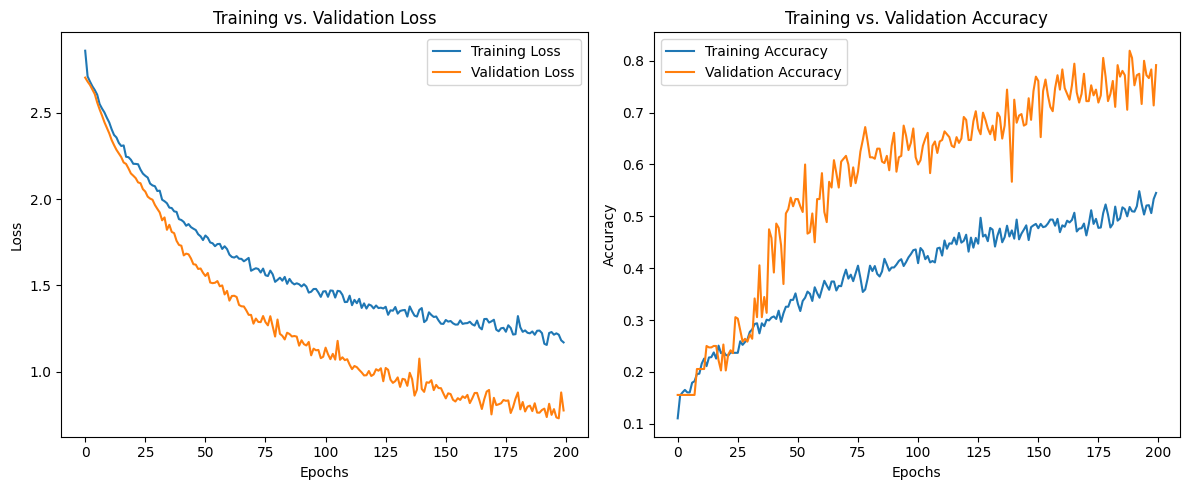

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predict on test data
y_pred = best_model.predict(X_test)

# Convert one-hot encoded labels back to class indices
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

       A_100       1.00      1.00      1.00        25
        A_20       0.93      0.93      0.93        15
        A_40       0.71      0.81      0.76        21
        A_60       0.61      0.73      0.67        26
        A_80       1.00      0.61      0.76        23
       B_100       1.00      1.00      1.00        17
        B_20       0.95      1.00      0.97        18
        B_40       1.00      0.95      0.97        19
        B_60       0.86      1.00      0.92        18
        B_80       1.00      0.83      0.91        18
       C_100       0.72      1.00      0.84        18
        C_20       1.00      0.86      0.93        22
        C_40       1.00      1.00      1.00        24
        C_60       1.00      0.68      0.81        19
        C_80       0.70      0.67      0.68        21
     Healthy       0.93      1.00      0.97        56

    accuracy                           0

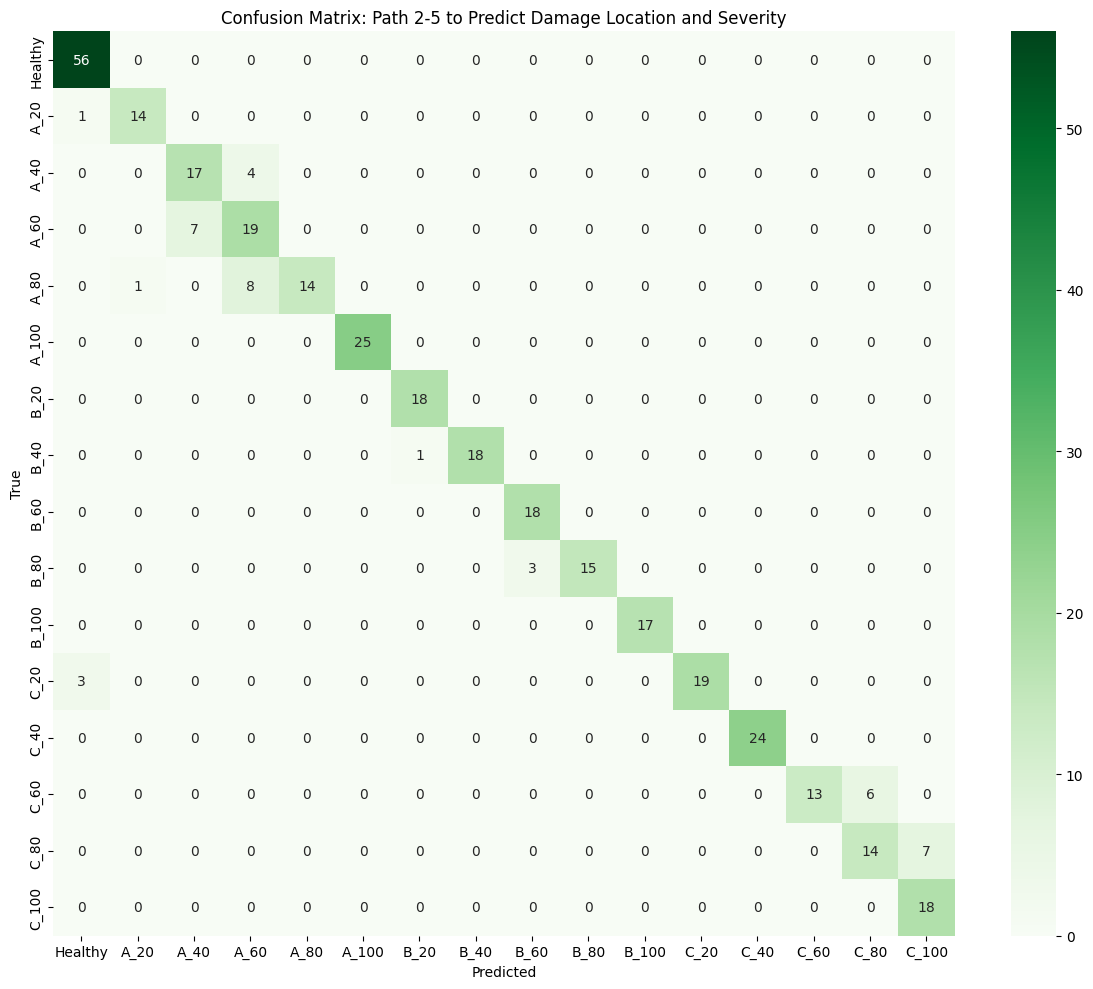

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict
y_pred_probs = best_model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Decode labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_true_labels = label_encoder.inverse_transform(y_true)

# Classification Report
print(classification_report(y_true_labels, y_pred_labels))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=label_encoder.transform(ordered_labels))

# Plot with correct label names
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, xticklabels=ordered_labels, yticklabels=ordered_labels, cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Path 2-5 to Predict Damage Location and Severity")
plt.tight_layout()
plt.show()

# Adding noise to test for robustness

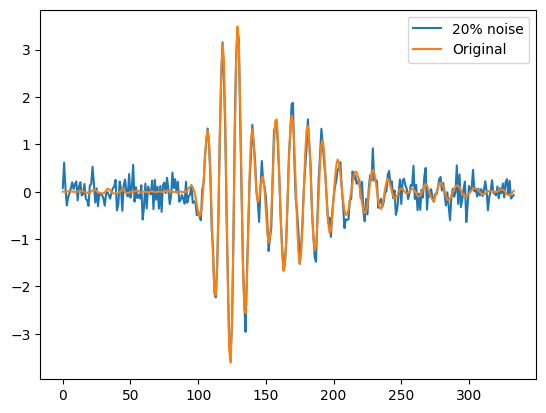

(1440, 334, 1)
0.9980872


In [ ]:
X_train_noisy = X_train + 0.2 * np.random.normal(loc=0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + 0.2 * np.random.normal(loc=0, scale=1.0, size=X_test.shape)

plt.plot(X_train_noisy[0])
plt.plot(X_train[0])
plt.legend(['20% noise', 'Original'])
plt.show()
print(X_train_noisy.shape)
std = np.std(X_train)
print(std)

**training on clean, testing on noisy**

In [ ]:
from sklearn.metrics import accuracy_score

noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2] # clean, 1%, 5%, 10%, 20%
noise_accuracies = []
for noise_level in noise_levels:
    # Add noise to the testing data
    print(f"Evaluating Non-noise trained model with noise level: {noise_level}")
    X_test_noisy = X_test + noise_level * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)  # creates a normal distribution for the noise. Assumes a mean of 0 and std of 1.0

    # predict for this noise level
    y_pred_probs = best_model.predict(X_test_noisy)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # accuracy
    accuracy_noise = accuracy_score(y_true, y_pred)
    noise_accuracies.append(accuracy_noise)
    print(f"Accuracy with noise level {noise_level}: {accuracy_noise}")

Evaluating Non-noise trained model with noise level: 0.0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy with noise level 0.0: 0.8861111111111111
Evaluating Non-noise trained model with noise level: 0.01
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy with noise level 0.01: 0.7888888888888889
Evaluating Non-noise trained model with noise level: 0.05
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy with noise level 0.05: 0.45555555555555555
Evaluating Non-noise trained model with noise level: 0.1
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy with noise level 0.1: 0.26944444444444443
Evaluating Non-noise trained model with noise level: 0.2
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy with noise level 0.2: 0.17222222222222222


**training on respective noise level**

In [ ]:
from sklearn.metrics import accuracy_score

noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2] # clean, 1%, 5%, 10%, 20%
noise_accuracies_trained_on_noise = []
for noise_level in noise_levels:
    # Add noise to the training and testing data
    print(f"Evaluating {noise_level} noise trained model with noise level: {noise_level}")
    X_train_noisy = X_train + noise_level * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
    X_test_noisy = X_test + noise_level * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)  # creates a normal distribution for the noise. Assumes a mean of 0 and std of 1.0

    # train model for this noise level
    # Set all seeds to ensure reproducibility
    RANDOM_SEED = 42
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)
    set_random_seed(RANDOM_SEED)

    best_noise_model = Sequential()

    # First Conv1D + BatchNorm + Pool
    best_noise_model.add(Conv1D(
        filters=32,
        kernel_size=5,
        activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    best_noise_model.add(BatchNormalization())
    best_noise_model.add(MaxPooling1D(pool_size=2))

    # Second Conv1D + BatchNorm + Pool
    best_noise_model.add(Conv1D(
        filters=32,
        kernel_size=5,
        activation='relu'
    ))
    best_noise_model.add(BatchNormalization())
    best_noise_model.add(MaxPooling1D(pool_size=2))

    # Dropout to prevent overfitting
    best_noise_model.add(Dropout(0.2))

    best_noise_model.add(Flatten())
    best_noise_model.add(Dense(64, activation='relu'))
    best_noise_model.add(Dense(y_train.shape[1], activation='softmax'))  # 16-class output

    best_noise_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # train
    history = best_noise_model.fit(
        X_train_noisy, y_train,
        epochs=300,  # Adjust based on performance
        batch_size=32,  # Common choice, can be tuned
        validation_data=(X_test_noisy, y_test),
        verbose=0
    )

    # predict for this noise level
    y_pred_probs = model.predict(X_test_noisy)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # accuracy
    accuracy_noise = accuracy_score(y_true, y_pred)
    noise_accuracies_trained_on_noise.append(accuracy_noise)
    print(f"Accuracy with noise level {noise_level}: {accuracy_noise}")

Evaluating Non-noise trained model with noise level: 0.0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy with noise level 0.0: 0.7916666666666666
Evaluating Non-noise trained model with noise level: 0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy with noise level 0.01: 0.7777777777777778
Evaluating Non-noise trained model with noise level: 0.05


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy with noise level 0.05: 0.6166666666666667
Evaluating Non-noise trained model with noise level: 0.1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy with noise level 0.1: 0.31666666666666665
Evaluating Non-noise trained model with noise level: 0.2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy with noise level 0.2: 0.15555555555555556


**model trained on 5% on other noise levels**

In [ ]:
X_train_noise_5 = X_train + 0.05 * np.random.normal(loc=0, scale=1.0, size=X_train.shape)

In [ ]:
# train model for this noise level
# Set all seeds to ensure reproducibility
RANDOM_SEED = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

best_noise_model_5 = Sequential()

# First Conv1D + BatchNorm + Pool
best_noise_model_5.add(Conv1D(
    filters=32,
    kernel_size=5,
    activation='relu',
    input_shape=(X_train_noise_5.shape[1], X_train_noise_5.shape[2])
    ))
best_noise_model_5.add(BatchNormalization())
best_noise_model_5.add(MaxPooling1D(pool_size=2))

# Second Conv1D + BatchNorm + Pool
best_noise_model_5.add(Conv1D(
    filters=32,
    kernel_size=5,
    activation='relu'))

best_noise_model_5.add(BatchNormalization())
best_noise_model_5.add(MaxPooling1D(pool_size=2))

# Dropout to prevent overfitting
best_noise_model_5.add(Dropout(0.2))

best_noise_model_5.add(Flatten())
best_noise_model_5.add(Dense(64, activation='relu'))
best_noise_model_5.add(Dense(y_train.shape[1], activation='softmax'))  # 16-class output

best_noise_model_5.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model on 5% noise data
best_noise_model_5.fit(
    X_train_noise_5, y_train,
    epochs=400,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/400
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.1111 - loss: 3.3015 - val_accuracy: 0.0521 - val_loss: 2.7253
Epoch 2/400
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.1438 - loss: 2.5197 - val_accuracy: 0.0521 - val_loss: 2.6379
Epoch 3/400
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2442 - loss: 2.3045 - val_accuracy: 0.1944 - val_loss: 2.5481
Epoch 4/400
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2610 - loss: 2.1790 - val_accuracy: 0.2569 - val_loss: 2.4569
Epoch 5/400
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2761 - loss: 2.0886 - val_accuracy: 0.2396 - val_loss: 2.3858
Epoch 6/400
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3232 - loss: 1.9933 - val_accuracy: 0.3194 - val_loss: 2.3456
Epoch 7/400
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3494 - loss: 1.9211 - val_accuracy: 0.1319 - val_loss: 2.3553
Epoch 8/400
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3555 - loss: 1.8720 - val_accuracy: 0.

In [ ]:
from sklearn.metrics import accuracy_score

noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2] # clean, 1%, 5%, 10%, 20%
noise_accuracies_trained_on_5_noise = []
for noise_level in noise_levels:
    # Add noise to the testing data
    print(f"Evaluating 5% noise trained model with noise level: {noise_level}")
    X_test_noisy = X_test + noise_level * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)  # creates a normal distribution for the noise. Assumes a mean of 0 and std of 1.0

    # predict for this noise level
    y_pred_probs = best_noise_model_5.predict(X_test_noisy)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    # accuracy
    accuracy_noise = accuracy_score(y_true, y_pred)
    noise_accuracies_trained_on_5_noise.append(accuracy_noise)
    print(f"Accuracy with noise level {noise_level}: {accuracy_noise}")

Evaluating 5% noise trained model with noise level: 0.0
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy with noise level 0.0: 0.6361111111111111
Evaluating 5% noise trained model with noise level: 0.01
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy with noise level 0.01: 0.6277777777777778
Evaluating 5% noise trained model with noise level: 0.05
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy with noise level 0.05: 0.5
Evaluating 5% noise trained model with noise level: 0.1
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy with noise level 0.1: 0.33611111111111114
Evaluating 5% noise trained model with noise level: 0.2
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy with noise level 0.2: 0.1361111111111111


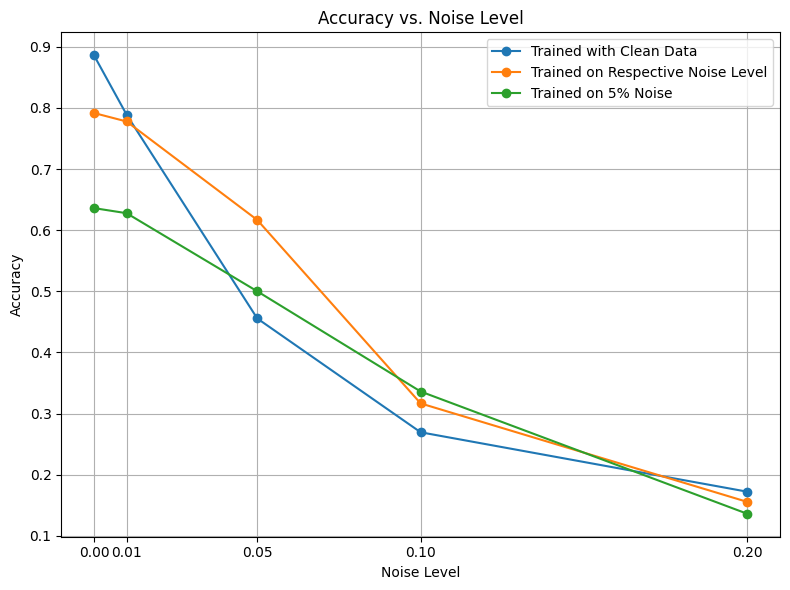

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(noise_levels, noise_accuracies, marker='o')
plt.plot(noise_levels, noise_accuracies_trained_on_noise, marker='o')
plt.plot(noise_levels, noise_accuracies_trained_on_5_noise, marker='o')
plt.xlabel('Noise Level')
plt.xticks(noise_levels)
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Noise Level')
plt.legend(['Trained with Clean Data', 'Trained on Respective Noise Level', 'Trained on 5% Noise'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Multiple Outputs, location and damage

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

inputs = Input(shape=(X.shape[1], 1))

x = Conv1D(32, 5, activation='relu')(inputs)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)
x = Flatten()(x)

# Branch 1: Damage classification
damage_out = Dense(64, activation='relu')(x)
damage_out = Dense(6, activation='softmax', name='damage_output')(damage_out)

# Branch 2: Location classification
location_out = Dense(64, activation='relu')(x)
location_out = Dense(3, activation='softmax', name='location_output')(location_out)

model = Model(inputs=inputs, outputs=[damage_out, location_out])
model.compile(optimizer='adam',
              loss={'damage_output': 'categorical_crossentropy', 'location_output': 'categorical_crossentropy'},
              metrics={'damage_output': 'accuracy', 'location_output': 'accuracy'})
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 334, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 330, 32)        │            192 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 165, 32)        │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 165, 32)        │              0 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 5280)           │              0 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │        337,984 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │        337,984 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ damage_output (Dense)     │ (None, 6)              │            390 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ location_output (Dense)   │ (None, 3)              │            195 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 676,745 (2.58 MB)

 Trainable params: 676,745 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, {'damage_output': y_d_train, 'location_output': y_l_train},
    validation_data=(X_test, {'damage_output': y_d_test, 'location_output': y_l_test}),
    epochs=200,
    batch_size=32
)

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - damage_output_accuracy: 0.1633 - damage_output_loss: 1.8530 - location_output_accuracy: 0.3086 - location_output_loss: 1.1164 - loss: 2.9694 - val_damage_output_accuracy: 0.1583 - val_damage_output_loss: 1.8117 - val_location_output_accuracy: 0.6056 - val_location_output_loss: 0.9816 - val_loss: 2.8018
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - damage_output_accuracy: 0.2001 - damage_output_loss: 1.7917 - location_output_accuracy: 0.5536 - location_output_loss: 0.9540 - loss: 2.7457 - val_damage_output_accuracy: 0.2056 - val_damage_output_loss: 1.7686 - val_location_output_accuracy: 0.8222 - val_location_output_loss: 0.7683 - val_loss: 2.5410
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - damage_output_accuracy: 0.2488 - damage_output_loss: 1.7546 - location_output_accuracy: 0.6708 - location_output_loss: 0.7571 - loss: 2.5117 - val_damage_output_accuracy: 0.2056 - val_damage_output_loss: 1.7167 - val_location_outp

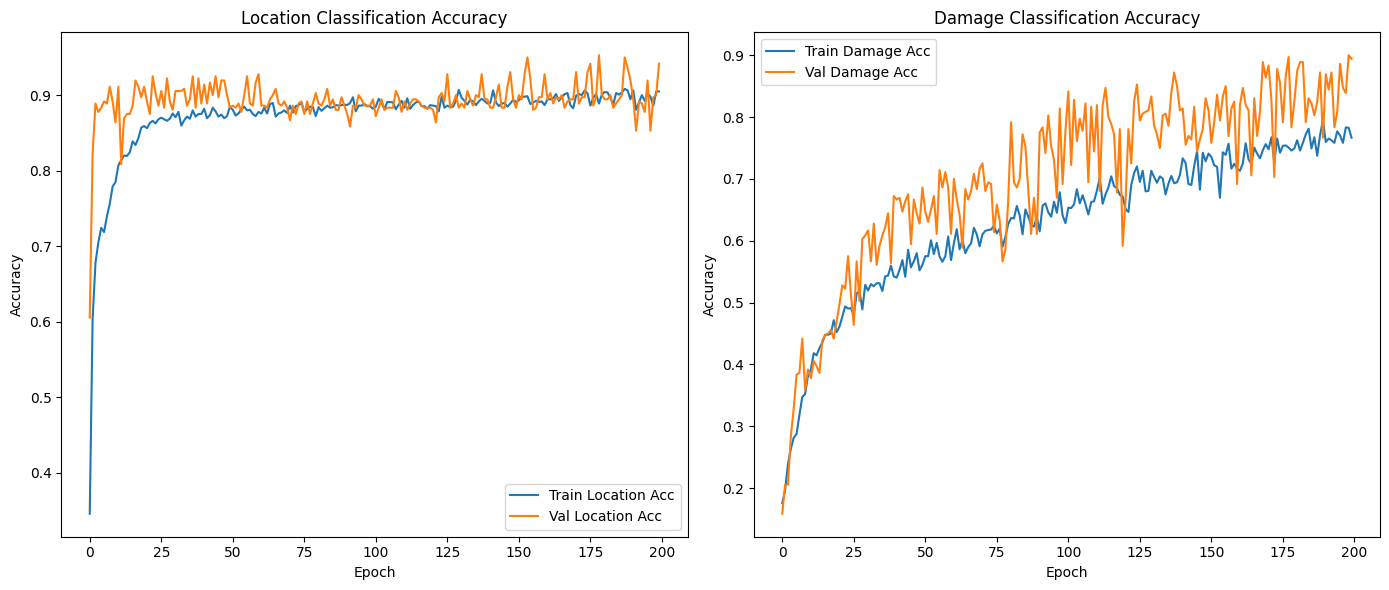

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot accuracy for both outputs
    plt.figure(figsize=(14, 6))

    # Location accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['location_output_accuracy'], label='Train Location Acc')
    plt.plot(history.history['val_location_output_accuracy'], label='Val Location Acc')
    plt.title('Location Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Damage accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['damage_output_accuracy'], label='Train Damage Acc')
    plt.plot(history.history['val_damage_output_accuracy'], label='Val Damage Acc')
    plt.title('Damage Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Evaluate model
results = model.evaluate(X_test, {
    "location_output": y_l_test,
    "damage_output": y_d_test
}, verbose=0)

# Print separate metrics
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Location Accuracy: {results[3]:.4f}")
print(f"Test Damage Accuracy: {results[4]:.4f}")


Test Loss: 0.5140
Test Location Accuracy: 0.8944
Test Damage Accuracy: 0.9417


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


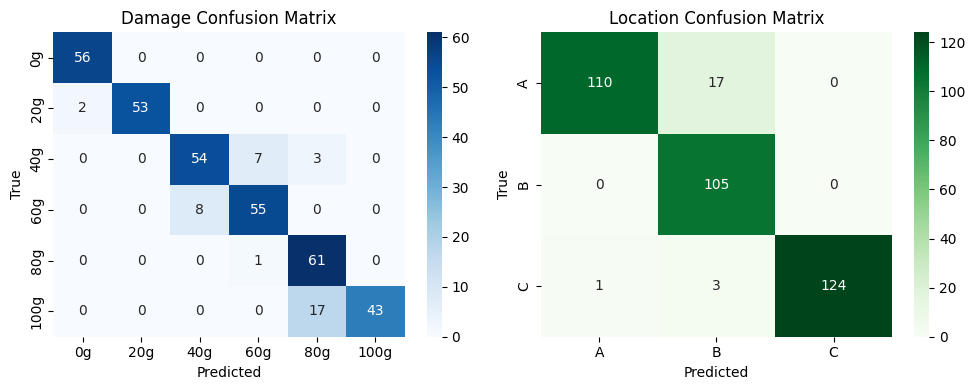

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Step 1: Predict
y_d_pred, y_l_pred = model.predict(X_test)

# Step 2: Convert one-hot back to class indices
y_d_pred_classes = np.argmax(y_d_pred, axis=1)
y_l_pred_classes = np.argmax(y_l_pred, axis=1)

y_d_true = np.argmax(y_d_test, axis=1)
y_l_true = np.argmax(y_l_test, axis=1)

# Step 3: Define class labels
damage_class_labels = ['0g', '20g', '40g', '60g', '80g', '100g']
location_class_labels = loc_encoder.classes_  # ['A', 'B', 'C']

# Step 4: Plot confusion matrix for damage classification
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
cm_d = confusion_matrix(y_d_true, y_d_pred_classes)
sns.heatmap(cm_d, annot=True, fmt='d', cmap='Blues',
            xticklabels=damage_class_labels,
            yticklabels=damage_class_labels)
plt.title('Damage Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Step 5: Plot confusion matrix for location classification
plt.subplot(1, 2, 2)
cm_l = confusion_matrix(y_l_true, y_l_pred_classes)
sns.heatmap(cm_l, annot=True, fmt='d', cmap='Greens',
            xticklabels=location_class_labels,
            yticklabels=location_class_labels)
plt.title('Location Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()